In [2]:
import polars as pl
import numpy as np
from datetime import datetime, timedelta

from data.cons_data import get_cons
from data.market_data import market_data

from utils.market_time import market_hours
from utils.params import PARAMS

from pairs_finding.pairs_identification import cointegration_pairs
from pairs_finding.clustering import Clustering

from trade.pairs_trader import PairsTrader
from trade.optimizer import optimizer

import warnings

warnings.filterwarnings("ignore")

In [3]:
params = {
    ("GOOGL", "GOOG"): {
        PARAMS.beta_win: 100,
        PARAMS.beta_freq: "1d",  # TBC
        PARAMS.z_win: 10,
        PARAMS.z_entry: 2,
        PARAMS.z_exit: 1,
        PARAMS.trade_freq: "1m",
    },
    ("GOOGL", "AAPL"): {
        PARAMS.beta_win: 100,
        PARAMS.beta_freq: "1d",  # TBC
        PARAMS.z_win: 10,
        PARAMS.z_entry: 2,
        PARAMS.z_exit: 1,
        PARAMS.trade_freq: "5m",
    },
}

In [4]:
etf = "QQQ"

cons = get_cons(etf=etf)
cons_date = cons.read()

data = market_data(
    file_path="C:/Users/edmun/OneDrive/Desktop/Quantitative Trading Strategies/Project/qts/data/"
)

quarter_dates = [i for i in cons_date.keys() if int(i[:4]) >= 2020]


perf = pl.DataFrame()
optimal_params_all = {}
for i in range(2, 3):  # range(2, len(quarter_dates))
    train_start, train_end, trade_end = (
        quarter_dates[i - 2],
        quarter_dates[i - 1],
        quarter_dates[i],
    )

    print(train_start, train_end, trade_end)
    # TRAINING PERIOD FINDING OPTIMAL PARAMS #
    data.read(cons=cons_date[train_end], start=train_start, end=train_end)

    train = data.resample_df(resample_freq="1h")

    c = Clustering(df=train.select(pl.all().exclude(["date", "time"])))

    c.run_clustering(method="kmeans", min_clusters=10, max_clusters=20)

    find_pairs = cointegration_pairs(
        df=train.select(pl.all().exclude(["date", "time"])),
        p_val_cutoff=0.05,
        cluster_pairs=c.cluster_pairs,
    )
    find_pairs.identify_pairs()

    pairs_to_trade = find_pairs.get_top_pairs(n=5)

    trader = PairsTrader(
        data=data,
        pairs=pairs_to_trade,  # list(params.keys()),  # pairs_to_trade
        params=None,
        trade_hour=market_hours.MARKET,
    )

    opt = optimizer(
        backtester=trader,
        pairs=pairs_to_trade,  # list(params.keys()), # pairs_to_trade
        start=pl.lit(train_start).str.strptime(pl.Date, "%Y-%m-%d"),
        end=pl.lit(train_end).str.strptime(pl.Date, "%Y-%m-%d"),
    )

    p = opt.optimize(n_trials=150)

    optimal_params = {}
    for key, value in p.items():
        parts = key.split("_")

        pair = (parts[0], parts[1])
        param_name = "_".join(parts[2:])

        if pair not in optimal_params:
            optimal_params[pair] = {}

        optimal_params[pair][param_name] = value

    # TRADING PERIOD USING PARAMS
    # next trading day
    last_date = datetime.strptime(train_end, "%Y-%m-%d")
    next_day = (last_date + timedelta(days=1)).strftime("%Y-%m-%d")

    # reading pairs only from next trading day to next q end
    data.read(
        cons=set([item for pair in list(optimal_params.keys()) for item in pair]),
        start=train_start,
        end=trade_end,
    )

    trader.params = optimal_params
    trader.update_data(data=data)

    pl_next_day = pl.lit(next_day).str.strptime(pl.Date, "%Y-%m-%d")
    pl_trade_end = pl.lit(trade_end).str.strptime(pl.Date, "%Y-%m-%d")
    returns = trader.backtest(start=pl_next_day, end=pl_trade_end)  # output pnl df?

    perf = pl.concat([perf, returns], how="vertical")
    optimal_params_all[(next_day, trade_end)] = optimal_params

    # del c, find_pairs, trader  # free ram


2020-03-31 2020-06-30 2020-09-30


  File "c:\Users\edmun\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\edmun\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\edmun\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\edmun\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


1


[I 2025-05-25 00:33:45,224] A new study created in memory with name: no-name-8952d561-07db-46ac-915e-3fc7c3e5f2fb


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-05-25 00:33:48,845] Trial 0 finished with value: -15.297434476569878 and parameters: {'TMUS_NTES_beta_win': 25, 'TMUS_NTES_z_win': 40, 'TMUS_NTES_z_entry': 2.2, 'TMUS_NTES_z_exit': -3.3, 'TMUS_NTES_trade_freq': '1m', 'ADBE_EA_beta_win': 95, 'ADBE_EA_z_win': 90, 'ADBE_EA_z_entry': 1.3, 'ADBE_EA_z_exit': -0.5999999999999996, 'ADBE_EA_trade_freq': '1m', 'ASML_NTES_beta_win': 80, 'ASML_NTES_z_win': 65, 'ASML_NTES_z_entry': 3.3000000000000003, 'ASML_NTES_z_exit': -2.5, 'ASML_NTES_trade_freq': '3m', 'ADBE_TMUS_beta_win': 70, 'ADBE_TMUS_z_win': 65, 'ADBE_TMUS_z_entry': 3.5, 'ADBE_TMUS_z_exit': -1.1999999999999997, 'ADBE_TMUS_trade_freq': '15m', 'KHC_ANSS_beta_win': 100, 'KHC_ANSS_z_win': 75, 'KHC_ANSS_z_entry': 3.1, 'KHC_ANSS_z_exit': -1.7, 'KHC_ANSS_trade_freq': '15m'}. Best is trial 0 with value: -15.297434476569878.
[I 2025-05-25 00:33:49,240] Trial 1 finished with value: 7.077581664772956 and parameters: {'TMUS_NTES_beta_win': 15, 'TMUS_NTES_z_win': 50, 'TMUS_NTES_z_entry': 0.3000

In [5]:
optimal_params_all

{('2020-07-01',
  '2020-09-30'): {('TMUS', 'NTES'): {'beta_win': 65,
   'z_win': 30,
   'z_entry': 0.7000000000000001,
   'z_exit': -3.0,
   'trade_freq': '15m'}, ('ADBE', 'EA'): {'beta_win': 90,
   'z_win': 40,
   'z_entry': 2.8000000000000003,
   'z_exit': -0.09999999999999964,
   'trade_freq': '1m'}, ('ASML', 'NTES'): {'beta_win': 50,
   'z_win': 80,
   'z_entry': 3.3000000000000003,
   'z_exit': -0.5,
   'trade_freq': '3m'}, ('ADBE', 'TMUS'): {'beta_win': 40,
   'z_win': 15,
   'z_entry': 1.3,
   'z_exit': -2.4,
   'trade_freq': '3m'}, ('KHC', 'ANSS'): {'beta_win': 70,
   'z_win': 75,
   'z_entry': 2.0,
   'z_exit': -2.0,
   'trade_freq': '1m'}}}

<Axes: >

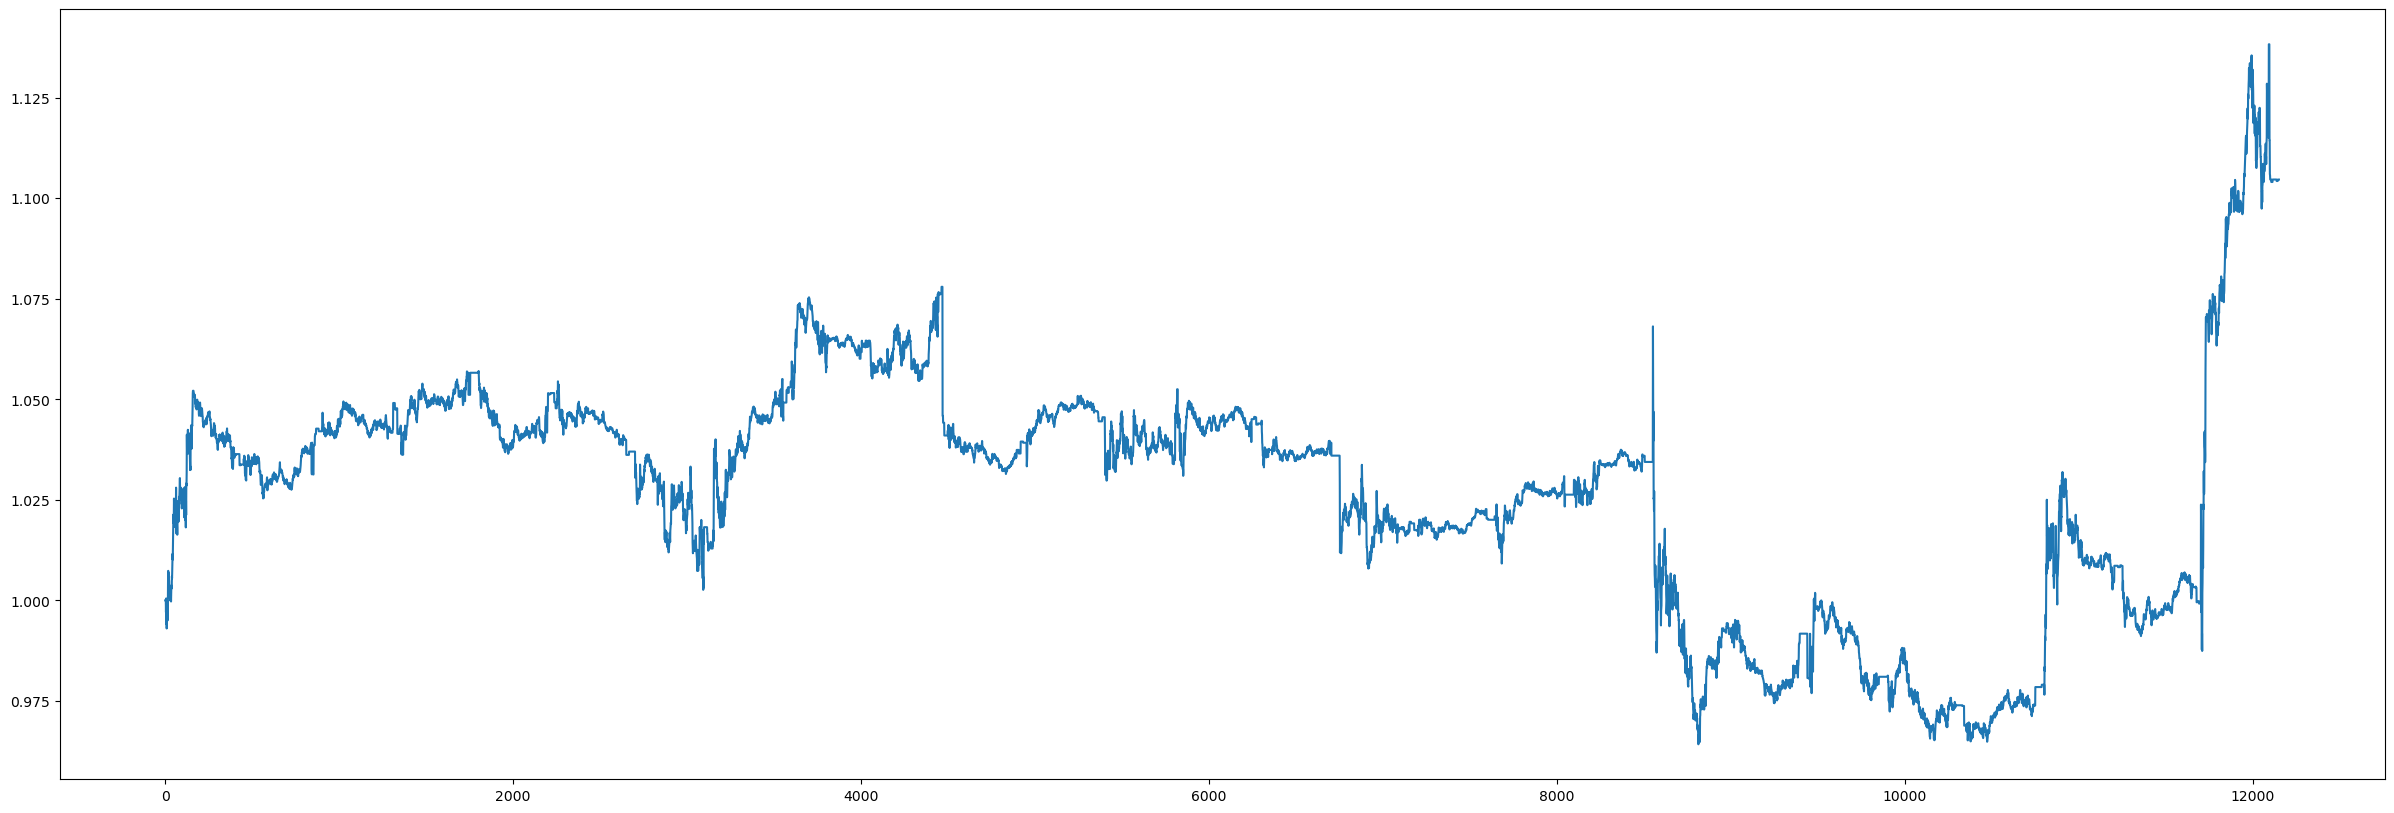

In [6]:
perf["CAPITAL"].to_pandas().plot(figsize=(30, 10))

<Axes: >

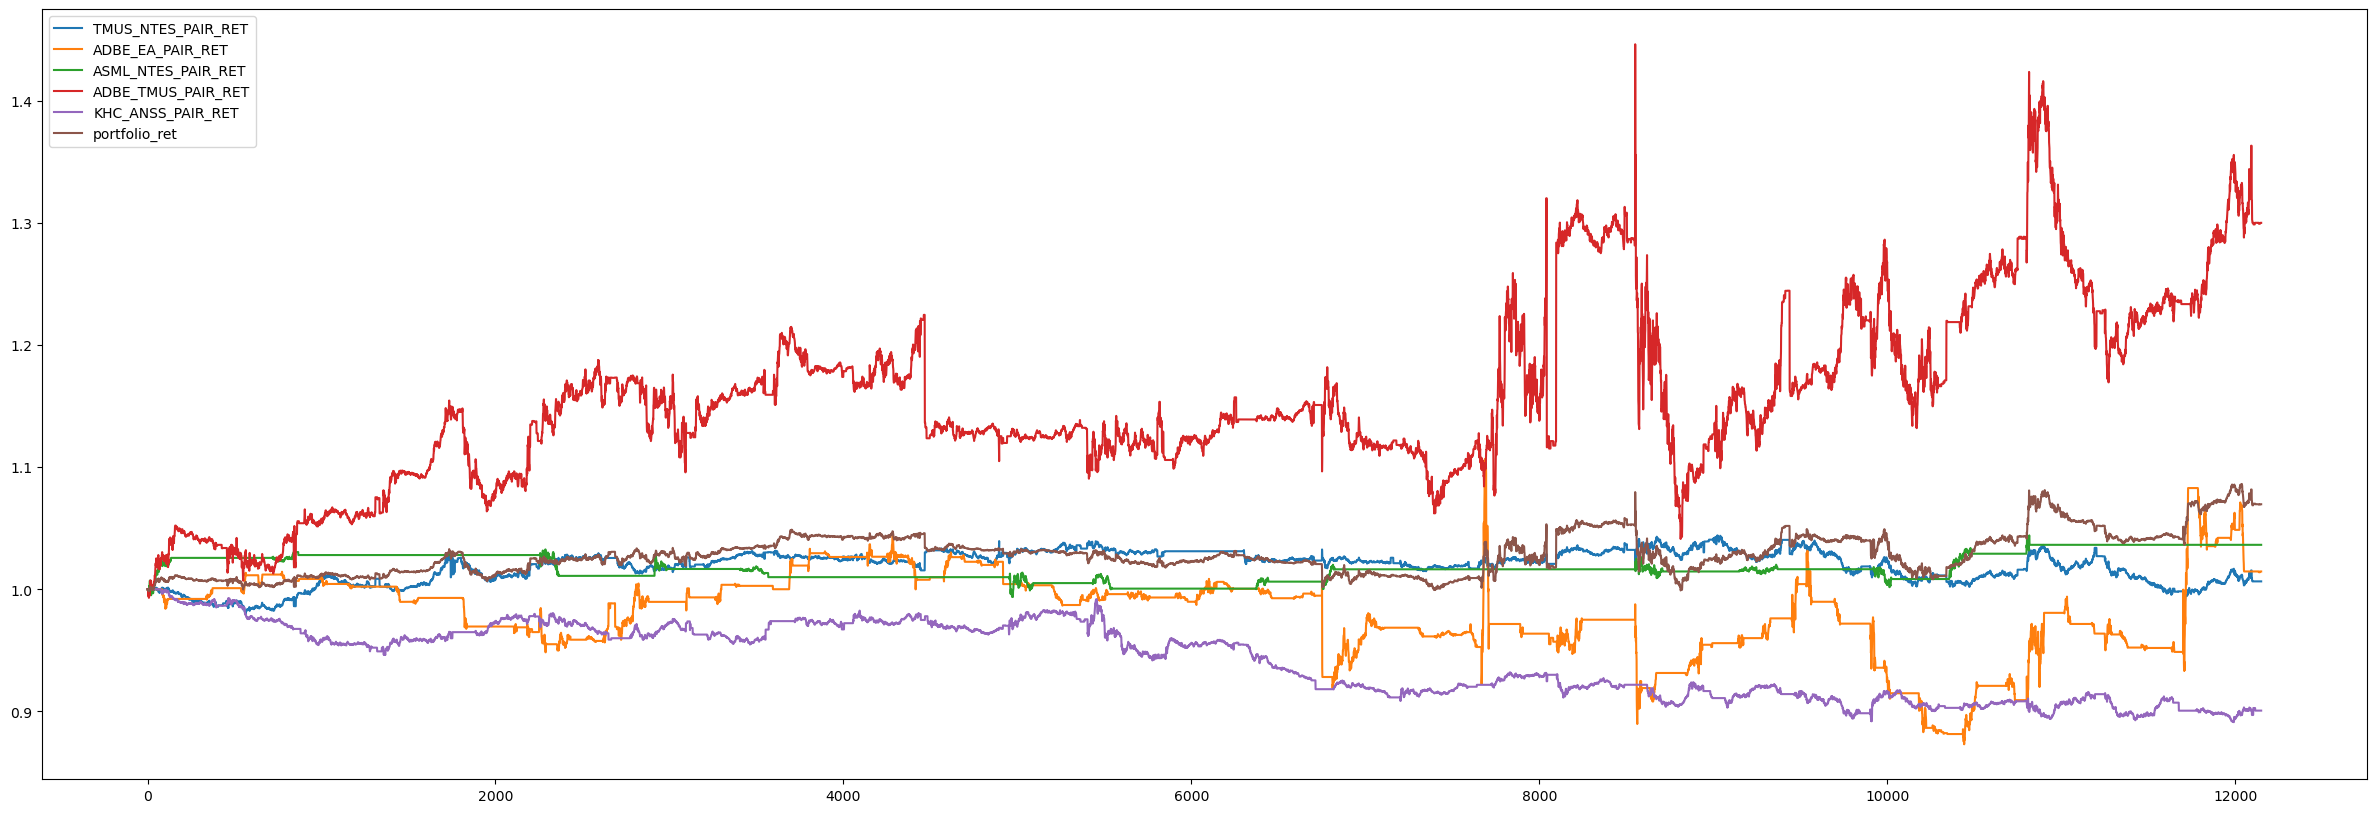

In [7]:
(
    perf.select([col for col in perf.columns if "_PAIR_RET" in col]).with_columns(
        pl.sum_horizontal(
            pl.all().exclude(["date", "time"]) * 1 / len(pairs_to_trade)
        ).alias("portfolio_ret")
    )
    + 1
).to_pandas().cumprod().plot(figsize=(30, 10))

<Axes: >

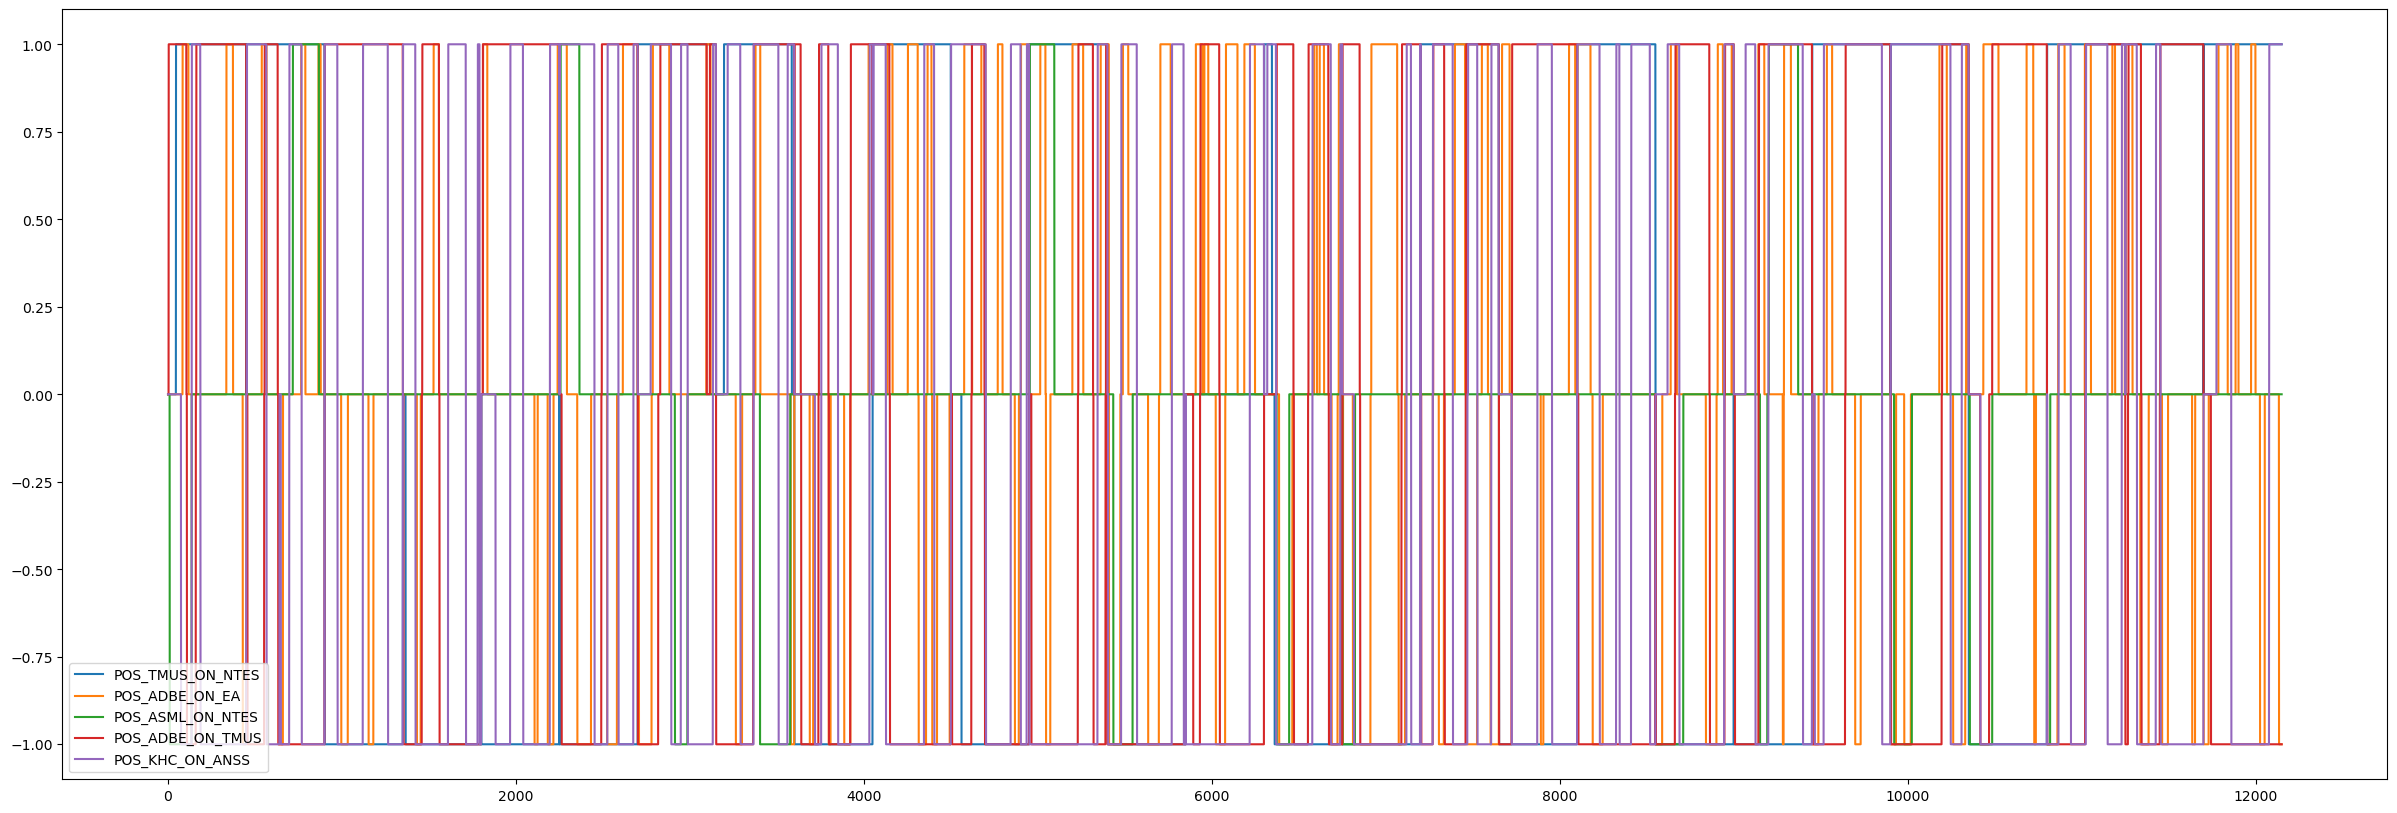

In [8]:
perf.select(
    [col for col in perf.columns if "POS" in col and "BETA" not in col]
).to_pandas().plot(figsize=(30, 10))

In [9]:
perf.select(
    [col for col in perf.columns if "POS" in col and "BETA" not in col]
).sum() / len(perf)

POS_TMUS_ON_NTES,POS_ADBE_ON_EA,POS_ASML_ON_NTES,POS_ADBE_ON_TMUS,POS_KHC_ON_ANSS
f64,f64,f64,f64,f64
0.006255,0.031276,-0.041975,-0.032593,-0.167984


In [10]:
bt_df = (
            perf.select("CAPITAL")
            .with_columns(pl.all().pct_change())
            .fill_null(0)
            .to_numpy()
            .flatten()
        )

sharpe = np.mean(bt_df) / np.std(bt_df) * np.sqrt(len(bt_df) * 252)
print('SHARPE: ', sharpe)

SHARPE:  11.745820759878082


In [11]:
np.cumprod(bt_df + 1)

array([1.        , 1.        , 1.        , ..., 1.10464755, 1.10464755,
       1.10464755])